# Query matching
In this notebook I will query images from the cornershop dataset and we will look for simular embeddings in the embedding gallary. The goal is to end up with a top 5,10 of matches.

In [1]:
%matplotlib inline

In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid #imagegrids for visualizing the top 10 matches
import PIL
from PIL import Image
from load_vissl_model import load_model #self defined function to reconstruct a vissl model
from pathlib import Path

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



## Loading embedding gallary
First we'll load a vissl model to use for inference:

In [3]:
#Specify the model below! Possible options are:
#"rotnet", "jigsaw", "moco", "simclr" and "swav"
model_name = "jigsaw"
model = load_model(model_name, verbose=True)

#checking for the best device to run model on
device = torch.device("cpu") 
# if(torch.cuda.is_available()):
#     device = torch.device("cuda")
#     model.to(device) #move model to gpu
print(f"using {device} device", end="\n\n")

In function load_model()
Train config at (relative path from vissl/...):
validation/jigsaw_full/train_config.yaml
SSL pretrained weights at:
/home/olivier/Documents/master/mp/checkpoints/sku110k/jigsaw_full/model_final_checkpoint_phase104.torch


/home/olivier/Documents/master/mp/.venv/lib/python3.8/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive config/validation/jigsaw_full/train_config.yaml in pkg://configs.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)


Model jigsaw was succusfully build
Weights for model jigsaw succesfully loaded
using cpu device



Now let's load the embedding gallary for this model:

In [4]:
#Gallary is stored in data folder with model_name as subfolder
dir = Path("data/" + model_name)

#Load torch stack of features
fts_stack = torch.load(dir / "embedding_gallary.torch")
print(f"fts_stack has shape {fts_stack.shape}")
print(f"Minimum value {fts_stack.min()}\nMaximum value {fts_stack.max()}")
print(f"4 example tensors from this stack:\n{fts_stack[0:5]}", end="\n\n")

#Load torch stack of normalized features
fts_stack_norm = torch.load(dir / "embedding_gallary_norm.torch")
print(f"fts_stack_norm has shape {fts_stack_norm.shape}")
print(f"Minimum value {fts_stack_norm.min()}\nMaximum value {fts_stack_norm.max()}")
print(f"4 example tensors from this stack:\n{fts_stack_norm[0:5]}", end="\n\n")

#load label list
labels = list()
with open(dir / "embedding_gallary_labels.txt", "r") as f:
    labels = f.read().splitlines()
    print(f"labels list has length "+ str(len(labels)))
    print(f"4 examples from the label list are: {labels[0:4]}")

fts_stack has shape torch.Size([1643, 2048])
Minimum value 0.12011190503835678
Maximum value 1.4710824489593506
4 example tensors from this stack:
tensor([[0.7661, 0.7171, 0.4983,  ..., 0.5895, 0.7678, 0.6631],
        [0.8055, 0.7272, 0.5350,  ..., 0.5711, 0.7725, 0.7237],
        [0.7580, 0.7097, 0.5222,  ..., 0.5315, 0.7456, 0.7228],
        [0.8191, 0.7283, 0.5581,  ..., 0.5402, 0.7770, 0.8149],
        [0.8385, 0.7117, 0.5577,  ..., 0.5355, 0.8056, 0.7523]])

fts_stack_norm has shape torch.Size([1643, 2048])
Minimum value 0.003550877096131444
Maximum value 0.0438569039106369
4 example tensors from this stack:
tensor([[0.0225, 0.0211, 0.0147,  ..., 0.0173, 0.0226, 0.0195],
        [0.0239, 0.0215, 0.0158,  ..., 0.0169, 0.0229, 0.0214],
        [0.0225, 0.0210, 0.0155,  ..., 0.0157, 0.0221, 0.0214],
        [0.0240, 0.0213, 0.0163,  ..., 0.0158, 0.0227, 0.0238],
        [0.0245, 0.0208, 0.0163,  ..., 0.0157, 0.0236, 0.0220]])

labels list has length 1643
4 examples from the label li

## Quering an image from CornerShop

In [5]:
#inference function
def extract_features(img_path:Path, model, verbose=False) -> torch.Tensor:
    """calculates the inference of an image (stored at img_path) using the model given. 
    Returns the feature vector torch.size([2048]).

    Args:
        img (Path): The image path for the image to feed to the neural net
        model (vissl model): Vissl model to use for inference.
        verbose (bool, optional): When True, you get prints from this function. Defaults to False.

    Returns:
        torch.Tensor: a feature vector with dimensions torch.size([2048])
    """
    image = Image.open(img_path)
    # Convert images to RGB. This is important
    # as the model was trained on RGB images.
    image = image.convert("RGB")

    # Image transformation pipeline.
    pipeline = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(256),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    #test time augmenting
    #take 10 crops
    width, height = image.size #Image size, in pixels. The size is given as a 2-tuple (width, height).
    ten_crops=transforms.functional.ten_crop(image, size=(height/2, width/2)) 
    #push them through the transform pipeline
    transformed_crops = [pipeline(crop) for crop in ten_crops]

    #unsqueeze adds a dim for batch size (with 1 element the entire input tensor of the image)
    features = [model(x.unsqueeze(0))[0] for x in transformed_crops] #send the 10 transfromed crops through the pipeline
    if(verbose):
        print(f"shape of the 10 embeddings from the 10 crops {torch.stack(features).shape}")
        
    #take the average embedding
    features_avg = torch.mean(torch.stack(features), dim=0)
    if(verbose):
        print(f"shape after averaging {features_avg.shape }")
    features_avg = features_avg.squeeze() #squeezing useless dimensions
    if(verbose):
        print(f"shape of features for returning: {features_avg.shape }")
    return features_avg

Collect the images:

In [6]:
#path where images are stored 
CornerShop = Path("/home/olivier/Documents/master/mp/CornerShop/CornerShop/crops")
img_paths = CornerShop.glob("*/*.jpg")
query_idx = -1

Query idx is 0, labels[0]=CawstonDry
Reading image at /home/olivier/Documents/master/mp/CornerShop/CornerShop/crops/CawstonDry/p40_0016.jpg


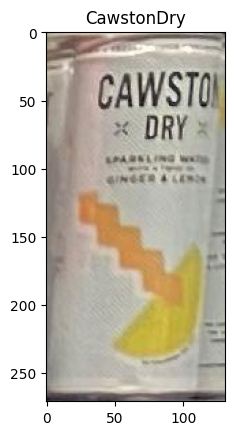

In [7]:
img_path = next(img_paths) #cycing trough the cornershop image dataset
query_idx+=1 #next label in list
label = img_path.parent.stem #extracting foldername as label for image
print(f"Query idx is {query_idx}, labels[{query_idx}]={labels[query_idx]}")
print(f"Reading image at {img_path}")
img = Image.open(img_path)
plt.title(label)
plt.imshow(img)

Calculate the embedding with the vissl model:

In [8]:
img_fts = extract_features(img_path,model,verbose=True)
print(f"feature vector has shape {img_fts.shape}")
print(f"The embedding vector looks like this: {img_fts}")

shape of the 10 embeddings from the 10 crops torch.Size([10, 1, 2048, 1, 1])
shape after averaging torch.Size([1, 2048, 1, 1])
shape of features for returning: torch.Size([2048])
feature vector has shape torch.Size([2048])
The embedding vector looks like this: tensor([0.7661, 0.7171, 0.4983,  ..., 0.5895, 0.7678, 0.6631])


In [9]:
#calulating the normalized features for our image
norm = img_fts.norm(dim=0,keepdim=False)
img_fts_norm = img_fts / norm

## Matching the query embedding to the gallary
In summary we have:
- The calculated embedding `img_fts` of our query image (as a torch.Tensor)
- The calculated normalized embedding `img_fts_norm` of our query image (as a torch.Tensor)
- The `query_idx`, which represents the index of our query embedding in the gallary embedding
- The `label` containing the ground truth for classification
- The embedding gallary `fts_stack` (as a torch.Tensor)
- The normalized embedding gallary `fts_stack_norm` (as a torch.Tensor)

Our goal is to match the query embedding to the best match in the gallary

In [10]:
#Converting our gallary to numpy arrays
fts_stack_np = fts_stack.numpy()
fts_stack_norm_np = fts_stack_norm.numpy()
#Converting our img_fts to numpy array
img_fts_np = img_fts.numpy()
img_fts_norm_np = img_fts_norm.numpy()
print("Conversion to numpy arrays succesfull")
print(f"dtype fts_stack_np={type(fts_stack_np)}\ndtype fts_stack_norm_np={type(fts_stack_norm_np)}")
print(f"dtype img_fts_np={type(img_fts_np)}")
print(f"dtype img_fts_norm_np={type(img_fts_norm_np)}")

Conversion to numpy arrays succesfull
dtype fts_stack_np=<class 'numpy.ndarray'>
dtype fts_stack_norm_np=<class 'numpy.ndarray'>
dtype img_fts_np=<class 'numpy.ndarray'>
dtype img_fts_norm_np=<class 'numpy.ndarray'>


In [11]:
#visualization for the matching results:
def show_top10(top10):
    """ Makes an imagegrid of the top 10 matches:
        Args:
            top10 : Array with indicis of the top10 matching embeddings from the gallary
    """
    #visualizing the top10
    top10_matches = [list(CornerShop.glob("*/*.jpg"))[i] for i in top10]
    imgs = [Image.open(top10_matches[i]) for i in range(len(top10_matches))]
    #creating matlab figure
    fig = plt.figure(figsize=(10., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 5),  # creates 2x5 grid of axes
                     axes_pad=0.4,  # pad between axes in inch.
                     )
    i=1
    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.set_title(f"Match #{i}")
        ax.imshow(im)
        i+=1

    plt.show()

In [25]:
def calc_top10(sim_vector, reverse_sort=True):
    """Extracts the top10 matches out of a simularity vector.
    This is done by performing an argsort on sim_vector.
    The result of argsort is returned.
    
    Args:
        sim_vector(np.array): simularity vector containing simularity scores with the query
        reverse_sort(boolean): True if higher simularity scores are considered better, False
        if lower simularity scores are considered better (e.g. euclidian distance, lower is better)
    """
    argsort_vector = np.argsort(sim_vector, kind="quicksort")
    if reverse_sort:
        #reverse order so best match is at the front of the array
        argsort_vector = argsort_vector[::-1] 
    #print("Top 10 matches with inner product as metric are:\n")
    top10 = argsort_vector[0:10]
    #print(top10, end="\n\n")
    print("Top10 label matches:")
    for rank,label_idx in enumerate(top10):
        print(f"{rank+1}.{labels[label_idx]}")
    print(f"\nGroud Truth = {label}")
    return top10

### Inner product (ip)

In [26]:
#Calulating the inner product of the query and all the embeddings in the gallary
print(f"img_fts {img_fts_np.shape} x fts_stack.T {fts_stack_np.T.shape}")
sim_vector_ip =  np.matmul(img_fts_np, fts_stack_np.T) #multiply the img_fts_np with every embedding in the gallary 
#The simularity vector contains a score that expresses how simular the query embedding 
#for each embedding in the embedding gallary
print(f"The sim_vector_ip looks like this: {sim_vector_ip}")
print(f"min     {sim_vector_ip.min()}")
print(f"max     {sim_vector_ip.max()}")
print(f"avg     {sim_vector_ip.mean()}")
print(f"std dev {sim_vector_ip.std()}")

img_fts (2048,) x fts_stack.T (2048, 1643)
The sim_vector_ip looks like this: [1154.9847 1146.5935 1146.2544 ... 1141.8523 1148.0156 1156.399 ]
min     1128.0450439453125
max     1173.4996337890625
avg     1153.899658203125
std dev 5.811341285705566


In [27]:
top10 = calc_top10(sim_vector_ip)

Top10 label matches:
1.CawstonRhubarb6x33cl
2.DesperadosBlikOriginal
3.DesperadosFles
4.CawstonRhubarb6x33cl
5.VittelCitroenMunt4x50cl
6.CawstonElderflower6x33cl
7.VittelCitroenMunt4x50cl
8.JustWater
9.CawstonOrange
10.JupilerBlik6x35,5cl

Groud Truth = CawstonDry


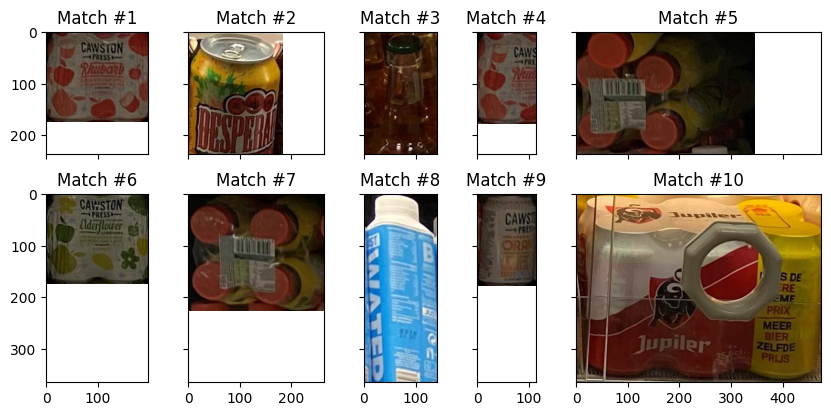

In [28]:
show_top10(top10=top10)

### Cosine simularity (cosim)

In [29]:
#Calulating the cosine simularity of the query and all the embeddings in the gallary
print(f"img_fts {img_fts_norm_np.shape} x fts_stack.T {fts_stack_norm_np.T.shape}")
sim_vector_cosim =  np.matmul(img_fts_norm_np, fts_stack_norm_np.T)  
print(f"The sim_vector_ip looks like this: {sim_vector_cosim}")
print(f"min     {sim_vector_cosim.min()}")
print(f"max     {sim_vector_cosim.max()}")
print(f"avg     {sim_vector_cosim.mean()}")
print(f"std dev {sim_vector_cosim.std()}")

img_fts (2048,) x fts_stack.T (2048, 1643)
The sim_vector_ip looks like this: [1.0000005  0.9993146  0.999162   ... 0.99907124 0.99893504 0.99913454]
min     0.9973562955856323
max     1.0000004768371582
avg     0.9987894892692566
std dev 0.0002693734422791749


In [30]:
top10 = calc_top10(sim_vector_cosim)

Top10 label matches:
1.CawstonDry
2.EvianFruits&PlantsCitroen
3.BarebellsVanilla
4.VittelCitroenMunt50cl
5.DashRaspberries
6.DashCucumber
7.CarrefourOrangeFles
8.CawstonDry
9.7upLemon
10.RedBullWhite

Groud Truth = CawstonDry


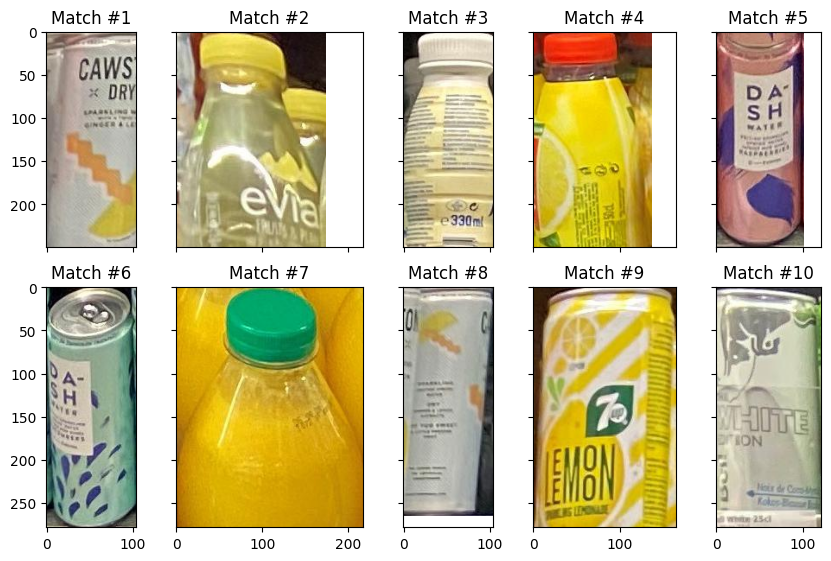

In [31]:
show_top10(top10=top10)

### Euclidian distance

In [32]:
eucl_dist = [] 
for gallary_embedding in fts_stack_np:
    #d(image_galary_embed, gallary_embedding)=euclid distance
    d_img_galemb = np.sqrt(np.sum(np.power(img_fts_np - gallary_embedding, 2))) 
    eucl_dist.append(d_img_galemb)
    
sim_vector_eucl_dist = np.array(eucl_dist)
print(f"The sim_vector_eucl_dist looks like this: {sim_vector_eucl_dist}")
print(f"min     {sim_vector_eucl_dist.min()}")
print(f"max     {sim_vector_eucl_dist.max()}")
print(f"avg     {sim_vector_eucl_dist.mean()}")
print(f"std dev {sim_vector_eucl_dist.std()}")


The sim_vector_eucl_dist looks like this: [0.        1.2751638 1.4058084 ... 1.4997679 1.5728742 1.4164072]
min     0.0
max     2.528500556945801
avg     1.6706384420394897
std dev 0.19096249341964722


In [33]:
top10 = calc_top10(sim_vector_eucl_dist, reverse_sort=False)

Top10 label matches:
1.CawstonDry
2.EvianFruits&PlantsCitroen
3.BarebellsVanilla
4.VittelCitroenMunt50cl
5.DashRaspberries
6.DashCucumber
7.CawstonDry
8.CarrefourOrangeFles
9.7upLemon
10.RedBullWhite

Groud Truth = CawstonDry


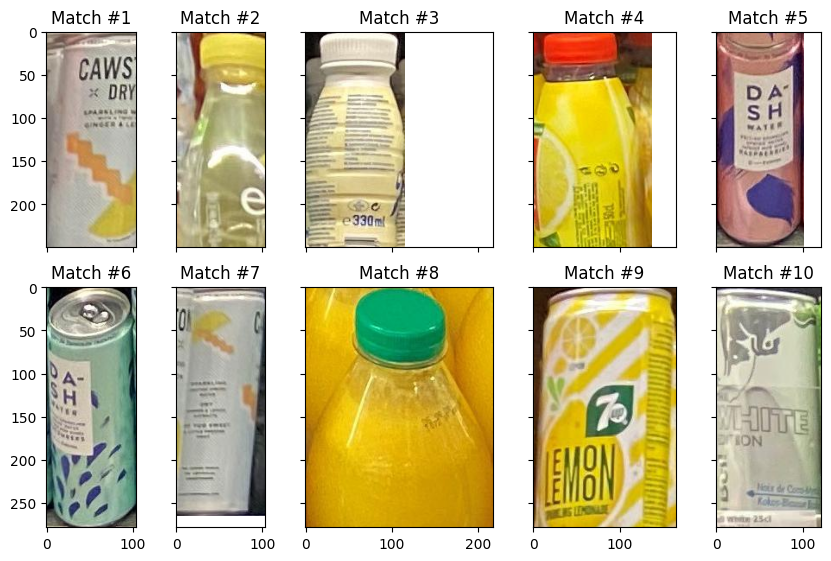

In [34]:
show_top10(top10=top10)

### Euclidian distance (normalized features)

In [35]:
eucl_dist_norm = [] 
for gallary_embedding in fts_stack_norm_np:
    #d(image_galary_embed, gallary_embedding)=euclid distance
    d_img_galemb = np.sqrt(np.sum(np.power(img_fts_norm_np - gallary_embedding, 2))) 
    eucl_dist_norm.append(d_img_galemb)
    
sim_vector_eucl_dist_norm = np.array(eucl_dist_norm)
print(f"The sim_vector_eucl_dist looks like this: {sim_vector_eucl_dist_norm}")
print(f"min     {sim_vector_eucl_dist_norm.min()}")
print(f"max     {sim_vector_eucl_dist_norm.max()}")
print(f"avg     {sim_vector_eucl_dist_norm.mean()}")
print(f"std dev {sim_vector_eucl_dist_norm.std()}")

The sim_vector_eucl_dist looks like this: [0.         0.03706153 0.04095294 ... 0.0431007  0.04612807 0.04158136]
min     0.0
max     0.07271429151296616
avg     0.048888593912124634
std dev 0.005598047748208046


In [36]:
top10 = calc_top10(sim_vector_eucl_dist_norm, reverse_sort=False)

Top10 label matches:
1.CawstonDry
2.EvianFruits&PlantsCitroen
3.BarebellsVanilla
4.VittelCitroenMunt50cl
5.DashRaspberries
6.DashCucumber
7.CarrefourOrangeFles
8.7upLemon
9.CawstonDry
10.RedBullWhite

Groud Truth = CawstonDry


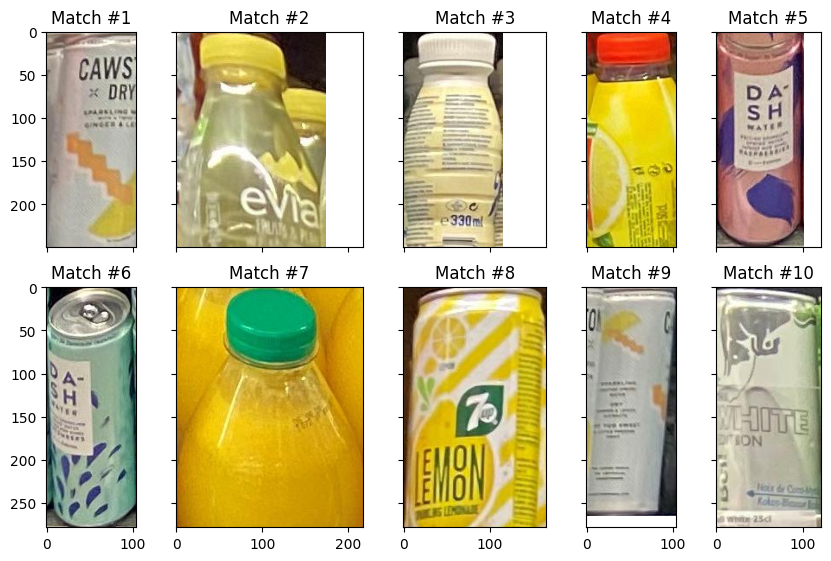

In [37]:
show_top10(top10=top10)